In [24]:
import os
os.chdir("/usr/src/app")
import xml.etree.ElementTree as ET
import pandas as pd
from os.path import join as jp
import cv2
import random
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
import re
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [25]:
from deepsetstats.paths import (
    PATH_VIDEOS,
    PATH_ANNOTATIONS_REFERENCE,
    PATH_ANNOTATIONS_REFERENCE_PARQUET
)
from deepsetstats.dataset.court_detection.utils import Utils

In [26]:
from deepsetstats.dataset.court_detection import utils 
from importlib import reload
utils = reload(utils)
Utils = utils.Utils

# <font size=20> Read CVAT Annotations

In [27]:
# Load and parse the XML file
tree = ET.parse(PATH_ANNOTATIONS_REFERENCE)
root = tree.getroot()

In [28]:
# Initialize lists to store the extracted data
image_ids = []
image_names = []
court_points = []
net_points = []

# Iterate through each 'image' element in the XML
for image in root.findall('.//image'):
    # Extract image id and name
    image_id = image.get('id')
    image_name = image.get('name')
    
    # Extract court points as a list of tuples
    court_point_str = image.find('.//points[@label="court"]').get('points')
    court_point_str = court_point_str.split(';')
    court_points_list = [(float(point.split(',')[0]), float(point.split(',')[1])) for point in court_point_str]
    
    # Extract net points as a list of tuples
    net_point_str = image.find('.//box[@label="net"]')
    net_x1 = float(net_point_str.get('xtl'))
    net_y1 = float(net_point_str.get('ytl'))
    net_x2 = float(net_point_str.get('xbr'))
    net_y2 = float(net_point_str.get('ybr'))
    
    net_points_list = [(net_x1, net_y1), (net_x2, net_y1), (net_x2, net_y2), (net_x1, net_y2)]
    
    # Append data to the lists
    image_ids.append(image_id)
    image_names.append(image_name)
    court_points.append(court_points_list)
    net_points.append(net_points_list)

# Create a DataFrame
data = {
    'image_id': image_ids,
    'image_name': image_names,
    'court': court_points,
    'net': net_points
}

df_annot = pd.DataFrame(data)

# Parse the name of the image to get the video_id, tournament_i and frame_id
df_annot[['image_name', 'level', 'tournament_id', 'video_id', 'frame_id']] = pd.DataFrame(df_annot["image_name"].map(Utils.full_parse_img_ref).tolist(), index=df_annot.index)

# Get different paths according to the origin of the youtube channel
df_annot["path_video"] = df_annot.apply(lambda row: Utils.path_video(row["video_id"]), axis=1)

In [33]:
# df_annot.to_parquet(PATH_ANNOTATIONS_REFERENCE_PARQUET, engine="pyarrow")

# <font size=20> Visualize annotations

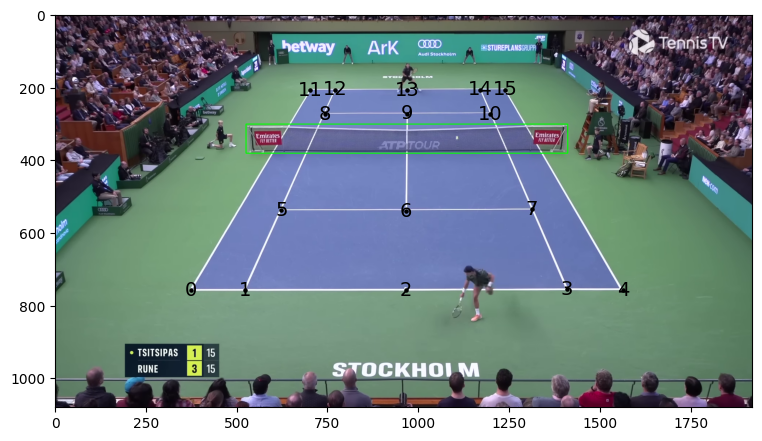

In [34]:
row_index = 43

# Assuming you have a DataFrame called 'df' and a specific row 'row_index' you want to process
row = df_annot.loc[row_index]

# Plot with keypoints
Utils.plot_frame_with_keypoints(
    video_id=row.video_id,
    frame_num=row.frame_id,
    size=(9,9),
    court_points=row.court,
    net_points=row.net
)

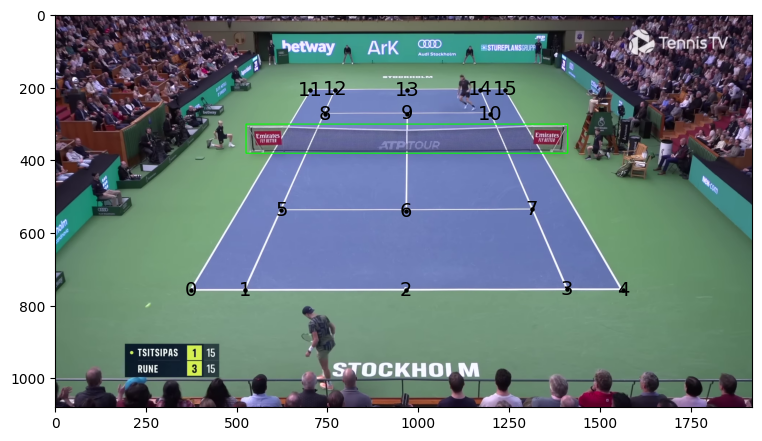

In [35]:
row_index = 43

# Assuming you have a DataFrame called 'df' and a specific row 'row_index' you want to process
row = df_annot.loc[row_index]

# Plot with keypoints
Utils.plot_frame_with_keypoints(
    video_id=row.video_id,
    frame_num=row.frame_id + add_frames,
    size=(9,9),
    court_points=row.court,
    net_points=row.net
)